In [1]:
from pyspark import SparkContext
import findspark
import numpy as np

sc = SparkContext("local[*]", "Ejercicio3")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/22 16:38:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# EJERCICIO 3

## CODIGO DEL EJERCICIO 1

In [2]:
def readFile (filename): 
    '''Arguments: 
    filename – name of the spam dataset file 
    12 columns: 11 features/dimensions (X) + 1 column with labels (Y) 
    Y -- Train labels (0 if normal traffic, 1 if botnet)  
    m rows: number of examples (m) 
    Returns: 
    An RDD containing the data of filename. Each example (row) of the file 
    corresponds to one RDD record. Each record of the RDD is a tuple (X,y).  
    “X” is an array containing the 11 features (float number) of an example  
    “y” is the 12th column of an example (integer 0/1) '''
    result = sc.textFile(filename)
    map_result = result.map(lambda row: [float(x) for x in row.split(",")])
    rdd_xy = map_result.map(lambda row: (row[:11],row[11]))
    return rdd_xy

In [3]:
# Prueba
data=readFile("./botnet_tot_syn_l.csv")
data.take(2)

[([9.012784269851089,
   1672.9999766891833,
   21.99998846107087,
   0.9999997452701503,
   61.99988768910407,
   69.99980788311223,
   13.000000232993186,
   2.9999999785934133,
   199.00000192395984,
   2468369573.0148935,
   2468372549.224571],
  1.0),
 ([3599.9990884099398,
   48206.57583515873,
   13362.999847123127,
   1.0000019205086303,
   262.99924185046257,
   82.99988759205826,
   13.999945225127506,
   5.000000032871429,
   216.99999612378573,
   1539044199.5873349,
   2468368394.7593513],
  0.0)]

In [4]:
rows_rdd = data.map(lambda line: line[0])
print(rows_rdd.take(1))
print()
cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
print(cols_rdd.take(5))
print()
group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
print(group_rdd.take(1))
print()
mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
print(mean_rdd.collect())
print()
broadcast_var = sc.broadcast(dict(mean_rdd.collect()))

[[9.012784269851089, 1672.9999766891833, 21.99998846107087, 0.9999997452701503, 61.99988768910407, 69.99980788311223, 13.000000232993186, 2.9999999785934133, 199.00000192395984, 2468369573.0148935, 2468372549.224571]]



[(0, (9.012784269851089, 81.23028029487523, 1)), (1, (1672.9999766891833, 2798928.9220020077, 1)), (2, (21.99998846107087, 483.9994922872514, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (61.99988768910407, 3843.9860734615186, 1))]



[(0, (1281538272.9462628, 4221233394864.5664, 1000000))]

[(0, (1281.5382729462629, np.float64(1605.8932249182935))), (9, (2130603014.3773189, np.float64(713843442.8521906))), (1, (21282.767194882716, np.float64(24117.4750428853))), (10, (2261491802.491662, np.float64(1301531949.9426913))), (2, (6948.057181364392, np.float64(16394.945350993465))), (3, (62631.1960911871, np.float64(134264.21801130084))), (4, (122198594.92861378, np.float64(233920713.61972862))), (5, (15722236.101999493, np.float64(44123779.49184376))), (6, (9.107313932259263, np.float64(5.281725807207843))), (7, (1.8897547959110095, np.float64(2.10134561021457))), (8, (124.27015928413205, np.float64(90.3431222388102)))]



In [5]:
import numpy as np

N = data.count()
sum_x, sum_sq_x = data.map(
    lambda line: (np.array(line[0]), np.array(line[0])**2)
).reduce(
    lambda a, b: (a[0] + b[0], a[1] + b[1])
)

mean = sum_x / N
variance = (sum_sq_x / N) - (mean**2)
std_dev = np.sqrt(variance)

In [6]:
def normalize (RDD_Xy): 
    '''Arguments: 
    RDD_Xy is an RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    Returns: 
    An RDD rescaled to N(0,1) in each column (mean=0, standard deviation=1) '''
    def map_normalize (RDD_Xy): 
        result = []
        x, y = RDD_Xy
        var = broadcast_var.value
        for i, x in enumerate(x):
             mean_aux, std_aux = var[i]
             if(std_aux!=0):
                 result.append((x - mean_aux)/std_aux)
             else:
                 result.append(0.0)
        return result, y
        
    rdd_norm = RDD_Xy.map(map_normalize)
    return rdd_norm

In [7]:
import numpy as np
def normalize_numpy(data): 
    N = data.count()
    sum_x, sum_sq_x = data.map(
        lambda line: (np.array(line[0]), np.array(line[0])**2)
    ).reduce(
        lambda a, b: (a[0] + b[0], a[1] + b[1])
    )
    mean = sum_x / N
    variance = (sum_sq_x / N) - (mean**2)
    std_dev = np.sqrt(variance)
    return data.map(lambda x: ((np.array(x[0]) - mean) / std_dev, x[1]))

In [138]:
rdd_norm = normalize(data)
print(rdd_norm.take(2))

[([np.float64(-0.792409774778866), np.float64(-0.8130937083307339), np.float64(-0.4224507642218906), np.float64(-0.4664697491193844), np.float64(-0.5223929554497563), np.float64(-0.35631956924945285), np.float64(0.7370102960327225), np.float64(0.5283496333423401), np.float64(0.8271779941619601), np.float64(0.4731661571170488), np.float64(0.15895172357621995)], 1.0), ([np.float64(1.443720404002351), np.float64(1.1163610034798641), np.float64(0.39127563577819524), np.float64(-0.4664697491031832), np.float64(-0.5223920961870128), np.float64(-0.35631927462193325), np.float64(0.9263319360863808), np.float64(1.480120748267978), np.float64(1.0264183320400917), np.float64(-0.8286954523619166), np.float64(0.15894853159524694)], 0.0)]


In [139]:
rdd_norm = normalize_numpy(data)
print(rdd_norm.take(2))

[(array([-0.79240977, -0.81309371, -0.42245076, -0.46646975, -0.52239296,
       -0.35631957,  0.7370103 ,  0.52834963,  0.82717799,  0.47316616,
        0.15895172]), 1.0), (array([ 1.4437204 ,  1.116361  ,  0.39127564, -0.46646975, -0.5223921 ,
       -0.35631927,  0.92633194,  1.48012075,  1.02641833, -0.82869545,
        0.15894853]), 0.0)]


In [7]:
# QUITAR: COMPROBACION SI DA 1 PARA CADA INDICE LA SUMA
import math
# comprobar que cada columna queda ~ media 0 y std 1
x_norm = rdd_norm.map(lambda xy: xy[0])

check = (
    x_norm
    .flatMap(lambda row: [(i, (v, v*v, 1)) for i, v in enumerate(row)])
    .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1], a[2]+b[2]))
    .mapValues(lambda t: (
        t[0]/t[2],  # mean
        math.sqrt(max((t[1]/t[2]) - (t[0]/t[2])**2, 0.0))  # std
    ))
    .collect()
)

print(sorted(check, key=lambda x: x[0]))
# medias ~ 0, std ~ 1 (salvo redondeo numérico)

[Stage 10:======>                                                   (1 + 8) / 9]

[(0, (np.float64(2.1223843305051558e-13), 1.0000000000002456)), (1, (np.float64(1.5998016067442222e-13), 0.9999999999997955)), (2, (np.float64(-1.5675792042202375e-13), 1.0000000000001086)), (3, (np.float64(-3.327419051402103e-14), 1.0000000000005203)), (4, (np.float64(-1.8289730974174744e-13), 1.000000000000649)), (5, (np.float64(3.3446667657699438e-15), 1.000000000000576)), (6, (np.float64(7.27877541351063e-13), 1.0000000000005016)), (7, (np.float64(1.207932442071069e-12), 0.999999999998659)), (8, (np.float64(-3.5423472866114026e-13), 1.000000000001496)), (9, (np.float64(4.06921856210829e-13), 1.0000000000008586)), (10, (np.float64(-1.776409703779791e-13), 1.000000000000181))]


In [8]:
# PRIMERA PRUEBA TRAIN
import numpy as np
import math

def sigmoid(z):
    if z >= 0:
        ez = math.exp(-z)
        return 1.0 / (1.0 + ez)
    else:
        ez = math.exp(z)
        return ez / (1.0 + ez)

def _sample_grad(xy, w, b):
    X, y = xy
    X = np.asarray(X, dtype=np.float64)
    y = float(y)

    z = float(np.dot(w, X) + b)
    y_hat = sigmoid(z)
    diff = y_hat - y

    grad_w = diff * X      # vector (11,)
    grad_b = diff          # escalar

    loss = -(y * math.log(y_hat)+(1-y)*math.log(1-y_hat))
    return (grad_w, grad_b, loss)

def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    '''Arguments: 
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent 
    lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
    Returns: 
    A list or array containing the weights “w” and bias “b”	at the end of the 
    training process'''	

    sc = RDD_Xy.context
    #data = RDD_Xy.cache()
    data = RDD_Xy
    
    m = data.count()
    if m == 0:
        raise ValueError("RDD_Xy vacío")

    k = len(data.first()[0])  # 11
    cost=[]
    # inicialización
    rng = np.random.default_rng(42)
    w = rng.normal(0, 0.01, size=k).astype(np.float64)
    b = float(rng.normal(0, 0.01))
    for i in range(iterations):
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # suma de gradientes por todo el dataset
        sum_grad_w, sum_grad_b, sum_loss = data.map(
            lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
        ).reduce(
            lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
        )

        bc_w.unpersist()
        bc_b.unpersist()

        # promedio + L2
        grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
        grad_b = (sum_grad_b / m)
        
        # update
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
        J = (sum_loss / m ) + reg_term
        #cost[i]=J
        
        print(f"Loss en iteracion {i}: {J}")

    return [w, b]

In [9]:
def accuracy (w, b, RDD_Xy): 
    '''Arguments: 
    w -- weights 
    b -- bias 
    RDD_Xy – RDD containing examples to be predicted  
    Returns: 
    accuracy -- the number of predictions that are correct divided by the number         
    of records (examples) in RDD_xy.  
    Predict function can be used for predicting a single example'''
    pred_ok = RDD_Xy.map(
            lambda xy: 1 if predict(w, b, xy[0]) == int(xy[1]) else 0
        )
    
    correct = pred_ok.reduce(lambda a, c: a + c)
    total = RDD_Xy.count()
    return correct / total if total > 0 else 0.0

In [10]:
def predict (w, b, X): 
    '''Arguments: 
    w -- weights 
    b -- bias 
    X – Example to be predicted  
     
    Returns: 
    Y_pred – a value (0/1) corresponding to the prediction of X '''
    threshold=0.5
    z = float(np.dot(np.asarray(w, dtype=float), np.asarray(X, dtype=float)) + float(b))
    p = sigmoid(z)
    return 1 if p >= threshold else 0

In [11]:
# read data
data=readFile("./botnet_tot_syn_l.csv")
# standarize
data = normalize(data)

ws = train(data,20,5,1.5)
print(ws)
w,b = ws
acc = accuracy(w,b,data)
print("acc:",acc)

Loss en iteracion 0: 1.1772191722773315


Loss en iteracion 1: 0.32462715001393155


Loss en iteracion 2: 0.5402173620958932


Loss en iteracion 3: 0.3632834877425628


Loss en iteracion 4: 0.5118173741994255


Loss en iteracion 5: 0.3687267669594059


Loss en iteracion 6: 0.49571392121164193


Loss en iteracion 7: 0.3722095544173298


Loss en iteracion 8: 0.48500134217087976


Loss en iteracion 9: 0.3749691304892487


Loss en iteracion 10: 0.47715155784254915


Loss en iteracion 11: 0.37736305589653585


Loss en iteracion 12: 0.4710826978773993


Loss en iteracion 13: 0.3795098119149038


Loss en iteracion 14: 0.46623643128374975


Loss en iteracion 15: 0.3814652843929716


Loss en iteracion 16: 0.46228583399035744


Loss en iteracion 17: 0.3832655483406209


Loss en iteracion 18: 0.4590228748274814


Loss en iteracion 19: 0.3849381560216514
[array([-0.08879325, -0.38010017, -0.16373531, -0.13972042, -0.59866127,
        0.39262985,  0.09355015, -0.51956591,  0.24746488,  0.31765464,
        0.22958299]), -0.06083725840413558]


[Stage 35:======>                                                   (1 + 8) / 9]

acc: 0.930565


## Configuracion utilizada

In [12]:
%pip install psutil

Note: you may need to restart the kernel to use updated packages.


In [13]:
import psutil

physical_cores = psutil.cpu_count(logical=False)
print(f"Physical cores: {physical_cores}")

Physical cores: 8


## EJERCICIO 3.1

### EJERCICIO 3.1.a

In [20]:
def train_dict(RDD_Xy, iterations, learning_rate, lambda_reg):
    '''Arguments: 
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent 
    lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
    Returns: 
    A tuple with dict and an array'''	

    sc = RDD_Xy.context
    #data = RDD_Xy.cache()
    data = RDD_Xy
    
    dict_iterations = {}
    
    m = data.count()
    if m == 0:
        raise ValueError("RDD_Xy vacío")

    k = len(data.first()[0])  # 11
    cost=[]
    # inicialización
    rng = np.random.default_rng(42)
    w = rng.normal(0, 0.01, size=k).astype(np.float64)
    b = float(rng.normal(0, 0.01))
    for i in range(iterations):
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # suma de gradientes por todo el dataset
        sum_grad_w, sum_grad_b, sum_loss = data.map(
            lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
        ).reduce(
            lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
        )

        bc_w.unpersist()
        bc_b.unpersist()

        # promedio + L2
        grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
        grad_b = (sum_grad_b / m)
        
        # update
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
        J = (sum_loss / m ) + reg_term
        dict_iterations[i] = J
        
        print(f"Loss en iteracion {i}: {J}")

    return dict_iterations, [w, b]

In [15]:
sc.stop()

In [23]:
from pyspark import SparkContext
import findspark
import numpy as np
#learning_rates=[1,2,3,4,5] 
learning_rates=[0.5,1,1.5,2,2.5,3,3.5] 
dict_result = {}

for i in learning_rates:

    sc = SparkContext("local[*]", "Practica1")
    # read data
    data=readFile("./botnet_tot_syn_l.csv")
    rows_rdd = data.map(lambda line: line[0])
    cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
    group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
    mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
    broadcast_var = sc.broadcast(dict(mean_rdd.collect()))
    # standarize
    data = normalize(data)
    ws = train_dict(data,10,i,1.5)
    dict_iterations, (w,b) = ws
    acc = accuracy(w,b,data)
    dict_result[i] = dict_iterations
    sc.stop()
        
print(dict_result)


Loss en iteracion 0: 0.6959452099601329


Loss en iteracion 1: 0.5791110261338918


Loss en iteracion 2: 0.5176833565217999


Loss en iteracion 3: 0.48275069558570977


Loss en iteracion 4: 0.46143992164983616


Loss en iteracion 5: 0.44772187099202937


Loss en iteracion 6: 0.4385233068974658


Loss en iteracion 7: 0.43215586795289496


Loss en iteracion 8: 0.4276343681958082


Loss en iteracion 9: 0.4243556328500333


Loss en iteracion 0: 0.7106303185763369


Loss en iteracion 1: 0.5096776874333373


Loss en iteracion 2: 0.4583950194138568


Loss en iteracion 3: 0.4379006426909544


Loss en iteracion 4: 0.42790564944936926


Loss en iteracion 5: 0.42246942729083514


Loss en iteracion 6: 0.4192974473368442


Loss en iteracion 7: 0.41735195901933586


Loss en iteracion 8: 0.4161128717538214


Loss en iteracion 9: 0.41529991203692335


Loss en iteracion 0: 0.7350128712139676


Loss en iteracion 1: 0.4639162504190137


Loss en iteracion 2: 0.43426456678832304


Loss en iteracion 3: 0.4235674128099919


Loss en iteracion 4: 0.4188121436589559


Loss en iteracion 5: 0.41645018378385024


Loss en iteracion 6: 0.4151902316197589


Loss en iteracion 7: 0.4144843903393043


Loss en iteracion 8: 0.41407510833793515


Loss en iteracion 9: 0.4138318675862167


Loss en iteracion 0: 0.7690928678730251


Loss en iteracion 1: 0.43162857247984937


Loss en iteracion 2: 0.42126021038713696


Loss en iteracion 3: 0.4172438332334065


Loss en iteracion 4: 0.4153217159028245


Loss en iteracion 5: 0.41438140203690443


Loss en iteracion 6: 0.4139172138186027


Loss en iteracion 7: 0.4136854344335991


Loss en iteracion 8: 0.41356825556926496


Loss en iteracion 9: 0.413508283155576


Loss en iteracion 0: 0.8128703085535093


Loss en iteracion 1: 0.4072234395952118


Loss en iteracion 2: 0.41344433771448724


Loss en iteracion 3: 0.4145776986412445


Loss en iteracion 4: 0.4139492191128484


Loss en iteracion 5: 0.4136559066512603


Loss en iteracion 6: 0.41353226029132345


Loss en iteracion 7: 0.41348041481058395


Loss en iteracion 8: 0.41345857344920434


Loss en iteracion 9: 0.4134492922672868


Loss en iteracion 0: 0.8663451932554203


Loss en iteracion 1: 0.3873625493432686


Loss en iteracion 2: 0.4107397065485766


Loss en iteracion 3: 0.4133672643454446


Loss en iteracion 4: 0.41345771159560873


Loss en iteracion 5: 0.41345736649484155


Loss en iteracion 6: 0.4134463145956289


Loss en iteracion 7: 0.4134433179210173


Loss en iteracion 8: 0.4134422817880896


Loss en iteracion 9: 0.4134420907348525


Loss en iteracion 0: 0.9295175219787579


Loss en iteracion 1: 0.3699728805847509


Loss en iteracion 2: 0.415508397369845


Loss en iteracion 3: 0.4103955915487939


Loss en iteracion 4: 0.4144923726539645


Loss en iteracion 5: 0.41299252864987207


Loss en iteracion 6: 0.4136048746308256


Loss en iteracion 7: 0.41337472432935407


Loss en iteracion 8: 0.41346669188343754


Loss en iteracion 9: 0.413431998304233


{0.5: {0: 0.6959452099601329, 1: 0.5791110261338918, 2: 0.5176833565217999, 3: 0.48275069558570977, 4: 0.46143992164983616, 5: 0.44772187099202937, 6: 0.4385233068974658, 7: 0.43215586795289496, 8: 0.4276343681958082, 9: 0.4243556328500333}, 1: {0: 0.7106303185763369, 1: 0.5096776874333373, 2: 0.4583950194138568, 3: 0.4379006426909544, 4: 0.42790564944936926, 5: 0.42246942729083514, 6: 0.4192974473368442, 7: 0.41735195901933586, 8: 0.4161128717538214, 9: 0.41529991203692335}, 1.5: {0: 0.7350128712139676, 1: 0.4639162504190137, 2: 0.43426456678832304, 3: 0.4235674128099919, 4: 0.4188121436589559, 5: 0.41645018378385024, 6: 0.4151902316197589, 7: 0.4144843903393043, 8: 0.41407510833793515, 9: 0.4138318675862167}, 2: {0: 0.7690928678730251, 1: 0.43162857247984937, 2: 0.42126021038713696, 3: 0.4172438332334065, 4: 0.4153217159028245, 5: 0.41438140203690443, 6: 0.4139172138186027, 7: 0.4136854344335991, 8: 0.41356825556926496, 9: 0.413508283155576}, 2.5: {0: 0.8128703085535093, 1: 0.4072234

Note: you may need to restart the kernel to use updated packages.


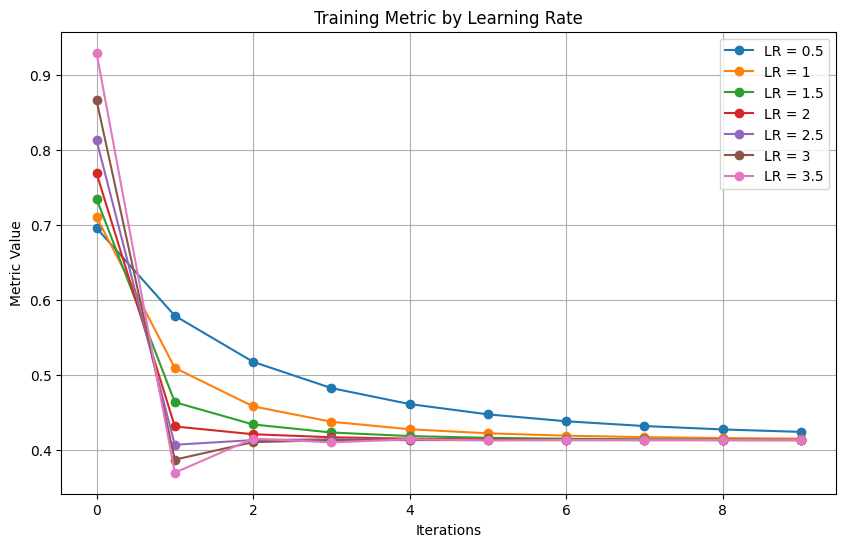

In [24]:
%pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for lr, metrics in dict_result.items():
    iterations = list(metrics.keys())
    values = list(metrics.values())
    plt.plot(iterations, values, marker='o', label=f'LR = {lr}')

plt.title('Training Metric by Learning Rate')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

### EJERCICIO 3.1 b

In [25]:
def train_dict(RDD_Xy, iterations, learning_rate, lambda_reg):
    '''Arguments: 
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent 
    lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
    Returns: 
    A tuple with dict and an array'''	

    sc = RDD_Xy.context
    #data = RDD_Xy.cache()
    data = RDD_Xy
    
    dict_iterations = {}
    
    m = data.count()
    if m == 0:
        raise ValueError("RDD_Xy vacío")

    k = len(data.first()[0])  # 11
    cost=[]
    # inicialización
    rng = np.random.default_rng(42)
    w = rng.normal(0, 0.01, size=k).astype(np.float64)
    b = float(rng.normal(0, 0.01))
    for i in range(iterations):
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # suma de gradientes por todo el dataset
        sum_grad_w, sum_grad_b, sum_loss = data.map(
            lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
        ).reduce(
            lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
        )

        bc_w.unpersist()
        bc_b.unpersist()

        # promedio + L2
        grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
        grad_b = (sum_grad_b / m)
        
        # update
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
        J = (sum_loss / m ) + reg_term
        dict_iterations[i] = J
        
        print(f"Loss en iteracion {i}: {J}")

    return dict_iterations, [w, b]

In [29]:
sc.stop()

In [30]:
from pyspark import SparkContext
import findspark
import numpy as np

# standarize
lambda_reg=[1,2,3,4,5] 
dict_result = {}

for i in lambda_reg:
    sc = SparkContext("local[*]", "Practica1")
    # read data
    data=readFile("./botnet_tot_syn_l.csv")
    rows_rdd = data.map(lambda line: line[0])
    cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
    group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
    mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
    broadcast_var = sc.broadcast(dict(mean_rdd.collect()))
    # standarize
    data = normalize(data)
    ws = train_dict(data,10,1.5,i)
    dict_iterations, (w,b) = ws
    acc = accuracy(w,b,data)
    dict_result[i] = dict_iterations
    sc.stop()
        
print(dict_result)


Loss en iteracion 0: 0.7203308124815132


Loss en iteracion 1: 0.44691465693479526


Loss en iteracion 2: 0.40810188414561455


Loss en iteracion 3: 0.3929466820096599


Loss en iteracion 4: 0.38564612149043564


Loss en iteracion 5: 0.3817293684438013


Loss en iteracion 6: 0.3794759422847844


Loss en iteracion 7: 0.3781119889249667


Loss en iteracion 8: 0.3772536798526492


Loss en iteracion 9: 0.37669685229035044


Loss en iteracion 0: 0.7496705622962473


Loss en iteracion 1: 0.4764493621732083


Loss en iteracion 2: 0.45462301966878604


Loss en iteracion 3: 0.4472289000920367


Loss en iteracion 4: 0.44418229493471245


Loss en iteracion 5: 0.44278706185200944


Loss en iteracion 6: 0.4421061935603698


Loss en iteracion 7: 0.441760407452724


Loss en iteracion 8: 0.4415800886424477


Loss en iteracion 9: 0.44148426131380186


Loss en iteracion 0: 0.7789153118093959


Loss en iteracion 1: 0.48978453914046105


Loss en iteracion 2: 0.48528473532072813


Loss en iteracion 3: 0.4827816524832978


Loss en iteracion 4: 0.48174160594801774


Loss en iteracion 5: 0.4813442008475358


Loss en iteracion 6: 0.4811925428889664


Loss en iteracion 7: 0.4811334712452705


Loss en iteracion 8: 0.4811098152941512


Loss en iteracion 9: 0.48110002435809485


Loss en iteracion 0: 0.8080700016191863


Loss en iteracion 1: 0.49025423168847954


Loss en iteracion 2: 0.5116792550420138


Loss en iteracion 3: 0.5090051989990618


Loss en iteracion 4: 0.5088730513939234


Loss en iteracion 5: 0.5087940581179493


Loss en iteracion 6: 0.508776836447643


Loss en iteracion 7: 0.5087712723035203


Loss en iteracion 8: 0.5087693576108959


Loss en iteracion 9: 0.5087685337872835


Loss en iteracion 0: 0.837139572323846


Loss en iteracion 1: 0.4811701638399356


Loss en iteracion 2: 0.5415331821545142


Loss en iteracion 3: 0.5265401092273085


Loss en iteracion 4: 0.5302895052404075


Loss en iteracion 5: 0.5293165603109389


Loss en iteracion 6: 0.5295634736063668


Loss en iteracion 7: 0.5294989807793975


Loss en iteracion 8: 0.5295149570375983


Loss en iteracion 9: 0.529510468772649


{1: {0: 0.7203308124815132, 1: 0.44691465693479526, 2: 0.40810188414561455, 3: 0.3929466820096599, 4: 0.38564612149043564, 5: 0.3817293684438013, 6: 0.3794759422847844, 7: 0.3781119889249667, 8: 0.3772536798526492, 9: 0.37669685229035044}, 2: {0: 0.7496705622962473, 1: 0.4764493621732083, 2: 0.45462301966878604, 3: 0.4472289000920367, 4: 0.44418229493471245, 5: 0.44278706185200944, 6: 0.4421061935603698, 7: 0.441760407452724, 8: 0.4415800886424477, 9: 0.44148426131380186}, 3: {0: 0.7789153118093959, 1: 0.48978453914046105, 2: 0.48528473532072813, 3: 0.4827816524832978, 4: 0.48174160594801774, 5: 0.4813442008475358, 6: 0.4811925428889664, 7: 0.4811334712452705, 8: 0.4811098152941512, 9: 0.48110002435809485}, 4: {0: 0.8080700016191863, 1: 0.49025423168847954, 2: 0.5116792550420138, 3: 0.5090051989990618, 4: 0.5088730513939234, 5: 0.5087940581179493, 6: 0.508776836447643, 7: 0.5087712723035203, 8: 0.5087693576108959, 9: 0.5087685337872835}, 5: {0: 0.837139572323846, 1: 0.4811701638399356,

Note: you may need to restart the kernel to use updated packages.


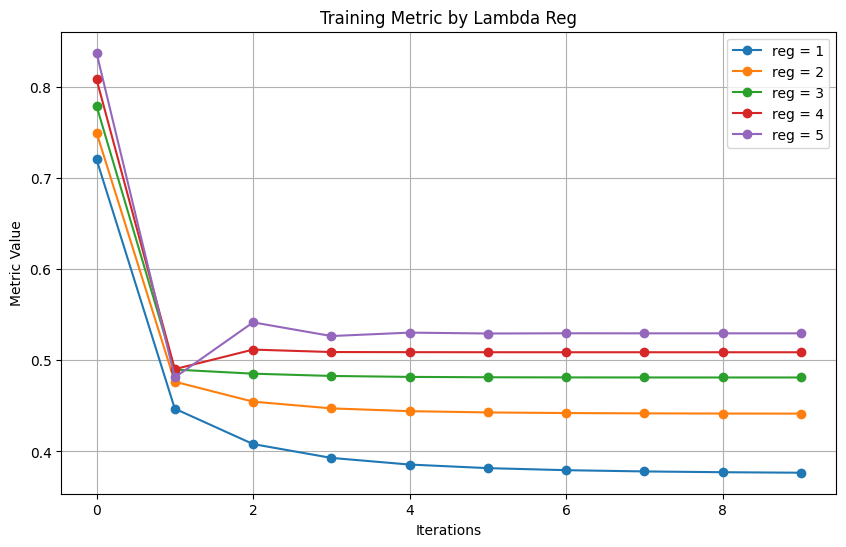

In [31]:
%pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for lr, metrics in dict_result.items():
    iterations = list(metrics.keys())
    values = list(metrics.values())
    plt.plot(iterations, values, marker='o', label=f'reg = {lr}')

plt.title('Training Metric by Lambda Reg')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

## EJERCICIO 3.2

In [16]:
sc.stop()

In [15]:
from pyspark import SparkContext
import findspark
import numpy as np
from time import perf_counter
from pyspark import SparkContext
import findspark
import numpy as np
sc = SparkContext("local[*]", "Practica1")


In [36]:
def readFile (filename): 
    '''Arguments: 
    filename – name of the spam dataset file 
    12 columns: 11 features/dimensions (X) + 1 column with labels (Y) 
    Y -- Train labels (0 if normal traffic, 1 if botnet)  
    m rows: number of examples (m) 
    Returns: 
    An RDD containing the data of filename. Each example (row) of the file 
    corresponds to one RDD record. Each record of the RDD is a tuple (X,y).  
    “X” is an array containing the 11 features (float number) of an example  
    “y” is the 12th column of an example (integer 0/1) '''
    result = sc.textFile(filename)
    map_result = result.map(lambda row: [float(x) for x in row.split(",")])
    rdd_xy = map_result.map(lambda row: (row[:11],row[11]))
    return rdd_xy

In [37]:
data=readFile("./botnet_tot_syn_l.csv")

In [38]:
rows_rdd = data.map(lambda line: line[0])
print(rows_rdd.take(1))
print()
cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
print(cols_rdd.take(5))
print()
group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
print(group_rdd.take(1))
print()
mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
print(mean_rdd.collect())
print()
broadcast_var = sc.broadcast(dict(mean_rdd.collect()))

[[9.012784269851089, 1672.9999766891833, 21.99998846107087, 0.9999997452701503, 61.99988768910407, 69.99980788311223, 13.000000232993186, 2.9999999785934133, 199.00000192395984, 2468369573.0148935, 2468372549.224571]]

[(0, (9.012784269851089, 81.23028029487523, 1)), (1, (1672.9999766891833, 2798928.9220020077, 1)), (2, (21.99998846107087, 483.9994922872514, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (61.99988768910407, 3843.9860734615186, 1))]



[(0, (1281538272.9462628, 4221233394864.5664, 1000000))]

[(0, (1281.5382729462629, np.float64(1605.8932249182935))), (9, (2130603014.3773189, np.float64(713843442.8521906))), (1, (21282.767194882716, np.float64(24117.4750428853))), (10, (2261491802.491662, np.float64(1301531949.9426913))), (2, (6948.057181364392, np.float64(16394.945350993465))), (3, (62631.1960911871, np.float64(134264.21801130084))), (4, (122198594.92861378, np.float64(233920713.61972862))), (5, (15722236.101999493, np.float64(44123779.49184376))), (6, (9.107313932259263, np.float64(5.281725807207843))), (7, (1.8897547959110095, np.float64(2.10134561021457))), (8, (124.27015928413205, np.float64(90.3431222388102)))]



In [39]:
def normalize (RDD_Xy): 
    '''Arguments: 
    RDD_Xy is an RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    Returns: 
    An RDD rescaled to N(0,1) in each column (mean=0, standard deviation=1) '''
    def map_normalize (RDD_Xy): 
        result = []
        x, y = RDD_Xy
        var = broadcast_var.value
        for i, x in enumerate(x):
             mean_aux, std_aux = var[i]
             if(std_aux!=0):
                 result.append((x - mean_aux)/std_aux)
             else:
                 result.append(0.0)
        return result, y
        
    rdd_norm = RDD_Xy.map(map_normalize)
    return rdd_norm

In [40]:
# PRIMERA PRUEBA TRAIN
import numpy as np
import math

def sigmoid(z):
    if z >= 0:
        ez = math.exp(-z)
        return 1.0 / (1.0 + ez)
    else:
        ez = math.exp(z)
        return ez / (1.0 + ez)

def _sample_grad(xy, w, b):
    X, y = xy
    X = np.asarray(X, dtype=np.float64)
    y = float(y)

    z = float(np.dot(w, X) + b)
    y_hat = sigmoid(z)
    diff = y_hat - y

    grad_w = diff * X      # vector (11,)
    grad_b = diff          # escalar

    loss = -(y * math.log(y_hat)+(1-y)*math.log(1-y_hat))
    return (grad_w, grad_b, loss)

def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    '''Arguments: 
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent 
    lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
    Returns: 
    A list or array containing the weights “w” and bias “b”	at the end of the 
    training process'''	

    sc = RDD_Xy.context
    #data = RDD_Xy.cache()
    data = RDD_Xy

    m = data.count()
    if m == 0:
        raise ValueError("RDD_Xy vacío")

    k = len(data.first()[0])  # 11
    cost=[]
    # inicialización
    rng = np.random.default_rng(42)
    w = rng.normal(0, 0.01, size=k).astype(np.float64)
    b = float(rng.normal(0, 0.01))
    for i in range(iterations):
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # suma de gradientes por todo el dataset
        sum_grad_w, sum_grad_b, sum_loss = data.map(
            lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
        ).reduce(
            lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
        )

        bc_w.unpersist()
        bc_b.unpersist()

        # promedio + L2
        grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
        grad_b = (sum_grad_b / m)
        
        # update
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
        J = (sum_loss / m ) + reg_term
        #cost[i]=J
        
        print(f"Loss en iteracion {i}: {J}")

    return [w, b]

In [41]:
def accuracy (w, b, RDD_Xy): 
    '''Arguments: 
    w -- weights 
    b -- bias 
    RDD_Xy – RDD containing examples to be predicted  
    Returns: 
    accuracy -- the number of predictions that are correct divided by the number         
    of records (examples) in RDD_xy.  
    Predict function can be used for predicting a single example'''
    pred_ok = RDD_Xy.map(
            lambda xy: 1 if predict(w, b, xy[0]) == int(xy[1]) else 0
        )
    
    correct = pred_ok.reduce(lambda a, c: a + c)
    total = RDD_Xy.count()
    return correct / total if total > 0 else 0.0

In [42]:
def predict (w, b, X): 
    '''Arguments: 
    w -- weights 
    b -- bias 
    X – Example to be predicted  
     
    Returns: 
    Y_pred – a value (0/1) corresponding to the prediction of X '''
    threshold=0.5
    z = float(np.dot(np.asarray(w, dtype=float), np.asarray(X, dtype=float)) + float(b))
    p = sigmoid(z)
    return 1 if p >= threshold else 0

In [46]:
sc.stop()

In [47]:
# read data
result = {}
for i in range(1, 11): # MODIFICAR CUANDO TENGAMOS LA EJECUCION FINAL (CORES + 3)
    sc = SparkContext(f"local[{i}]", f"Prueba_{i}")
    t0 = perf_counter()
    data=readFile("./botnet_tot_syn_l.csv").repartition(i)
    print(f'Experimento con número de workers {i}: particiones={data.getNumPartitions()}')
    rows_rdd = data.map(lambda line: line[0])
    cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
    group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
    mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
    broadcast_var = sc.broadcast(dict(mean_rdd.collect()))
    # standarize
    data = normalize(data)
    ws = train(data,10,1.5,0.0)
    w,b = ws
    acc = accuracy(w,b,data)
    print("acc:",acc)
    time = perf_counter() - t0
    result[i] = time
    sc.stop()
print(result)

Loss en iteracion 0: 0.690891121767007


Loss en iteracion 1: 0.39782222304284215


Loss en iteracion 2: 0.3286594783757808


Loss en iteracion 3: 0.2929002608142005


Loss en iteracion 4: 0.27011842342278614


Loss en iteracion 5: 0.2540488273343712


Loss en iteracion 6: 0.24199661404215023


Loss en iteracion 7: 0.23257497505040384


Loss en iteracion 8: 0.22498472951146412


Loss en iteracion 9: 0.2187278020351212


acc: 0.92944


Loss en iteracion 0: 0.6908911217669448


Loss en iteracion 1: 0.39782222304376336


Loss en iteracion 2: 0.32865947837623705


Loss en iteracion 3: 0.29290026081443543


Loss en iteracion 4: 0.27011842342291364


Loss en iteracion 5: 0.25404882733443535


Loss en iteracion 6: 0.24199661404220205


Loss en iteracion 7: 0.23257497505043465


Loss en iteracion 8: 0.22498472951147103


Loss en iteracion 9: 0.2187278020351126


acc: 0.92944


Loss en iteracion 0: 0.6908911217669459


Loss en iteracion 1: 0.3978222230435862


Loss en iteracion 2: 0.328659478376128


Loss en iteracion 3: 0.2929002608143776


Loss en iteracion 4: 0.27011842342287673


Loss en iteracion 5: 0.2540488273344233


Loss en iteracion 6: 0.24199661404219874


Loss en iteracion 7: 0.23257497505043173


Loss en iteracion 8: 0.22498472951146967


Loss en iteracion 9: 0.21872780203511782


acc: 0.92944


Loss en iteracion 0: 0.6908911217669641


Loss en iteracion 1: 0.39782222304340464


Loss en iteracion 2: 0.3286594783760316


Loss en iteracion 3: 0.2929002608143124


Loss en iteracion 4: 0.2701184234228289


Loss en iteracion 5: 0.2540488273343836


Loss en iteracion 6: 0.24199661404216946


Loss en iteracion 7: 0.23257497505040653


Loss en iteracion 8: 0.22498472951144727


Loss en iteracion 9: 0.2187278020350967


acc: 0.92944


Loss en iteracion 0: 0.6908911217669664


Loss en iteracion 1: 0.39782222304349746


Loss en iteracion 2: 0.3286594783760807


Loss en iteracion 3: 0.29290026081433684


Loss en iteracion 4: 0.27011842342283926


Loss en iteracion 5: 0.2540488273343869


Loss en iteracion 6: 0.24199661404216927


Loss en iteracion 7: 0.2325749750504026


Loss en iteracion 8: 0.22498472951144244


Loss en iteracion 9: 0.21872780203509398


acc: 0.92944


Loss en iteracion 0: 0.6908911217669632


Loss en iteracion 1: 0.39782222304361964


Loss en iteracion 2: 0.3286594783761502


Loss en iteracion 3: 0.2929002608143791


Loss en iteracion 4: 0.27011842342286496


Loss en iteracion 5: 0.25404882733440304


Loss en iteracion 6: 0.24199661404217956


Loss en iteracion 7: 0.23257497505040994


Loss en iteracion 8: 0.22498472951144943


Loss en iteracion 9: 0.21872780203509706


acc: 0.92944


Loss en iteracion 0: 0.6908911217669617


Loss en iteracion 1: 0.39782222304373127


Loss en iteracion 2: 0.32865947837621595


Loss en iteracion 3: 0.2929002608144255


Loss en iteracion 4: 0.27011842342289805


Loss en iteracion 5: 0.25404882733442957


Loss en iteracion 6: 0.2419966140421981


Loss en iteracion 7: 0.23257497505042696


Loss en iteracion 8: 0.2249847295114649


Loss en iteracion 9: 0.21872780203511005


acc: 0.92944


Loss en iteracion 0: 0.6908911217669622


Loss en iteracion 1: 0.39782222304376946


Loss en iteracion 2: 0.3286594783762404


Loss en iteracion 3: 0.29290026081444637


Loss en iteracion 4: 0.2701184234229153


Loss en iteracion 5: 0.25404882733444484


Loss en iteracion 6: 0.24199661404221195


Loss en iteracion 7: 0.23257497505044017


Loss en iteracion 8: 0.22498472951147697


Loss en iteracion 9: 0.218727802035122


acc: 0.92944


Loss en iteracion 0: 0.6908911217669622


Loss en iteracion 1: 0.3978222230437528


Loss en iteracion 2: 0.3286594783762358


Loss en iteracion 3: 0.2929002608144467


Loss en iteracion 4: 0.27011842342291986


Loss en iteracion 5: 0.25404882733445133


Loss en iteracion 6: 0.24199661404221798


Loss en iteracion 7: 0.23257497505044655


Loss en iteracion 8: 0.22498472951148313


Loss en iteracion 9: 0.21872780203512818


acc: 0.92944


Loss en iteracion 0: 0.6908911217669622


Loss en iteracion 1: 0.3978222230437395


Loss en iteracion 2: 0.3286594783762321


Loss en iteracion 3: 0.2929002608144481


Loss en iteracion 4: 0.2701184234229223


Loss en iteracion 5: 0.25404882733445544


Loss en iteracion 6: 0.24199661404222214


Loss en iteracion 7: 0.23257497505045124


Loss en iteracion 8: 0.22498472951148762


Loss en iteracion 9: 0.21872780203513265


acc: 0.92944
{1: 99.99702490100003, 2: 51.9612422109999, 3: 37.737067496000236, 4: 29.45095022700025, 5: 25.205010786000003, 6: 22.372203045999868, 7: 20.286989618000007, 8: 18.666834825000024, 9: 17.696939740999824, 10: 17.50320561000035}


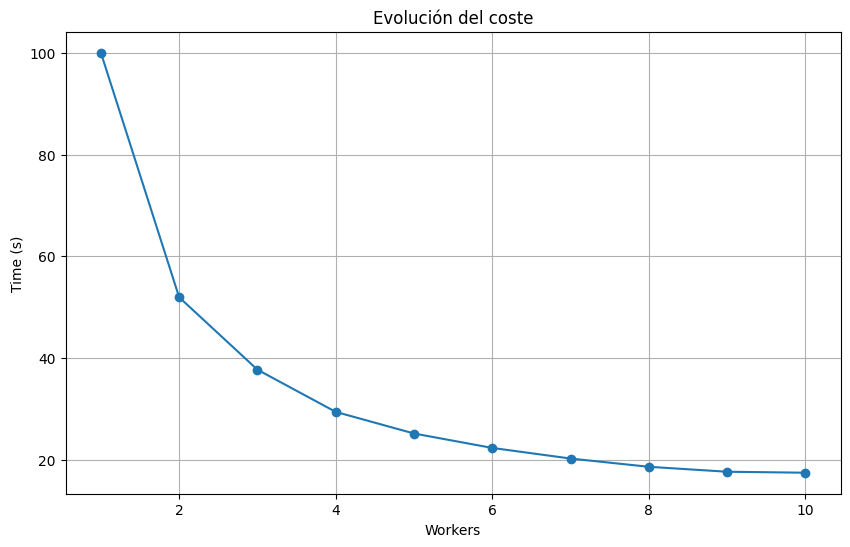

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

xs = sorted(result.keys())
ys = [result[x] for x in xs]

plt.plot(xs, ys, marker='o')   # línea + puntos
plt.xlabel("Workers")
plt.ylabel("Time (s)")
plt.title("Evolución del coste")
plt.grid(True)
plt.show()


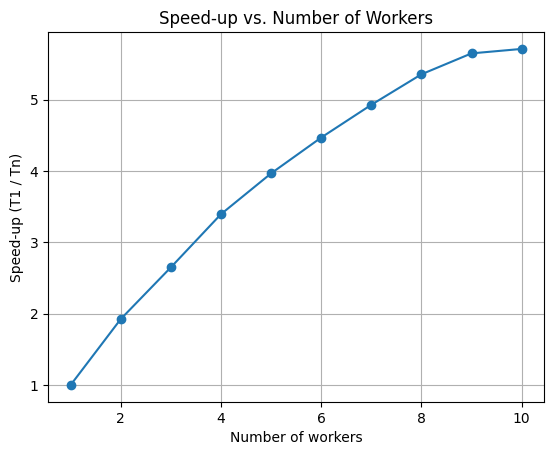

In [49]:
workers = sorted(result.keys())
t1 = result[1]  # baseline

speedup = {w: t1 / result[w] for w in workers}

# plot
plt.plot(workers, [speedup[w] for w in workers], marker="o")
plt.xlabel("Number of workers")
plt.ylabel("Speed-up (T1 / Tn)")
plt.title("Speed-up vs. Number of Workers")
plt.grid(True)
plt.show()

## EJERCICIO 3.3

In [ ]:
# PRIMERA PRUEBA: NO CACHE 

In [51]:
sc.stop()

In [70]:
def readFile (filename): 
    '''Arguments: 
    filename – name of the spam dataset file 
    12 columns: 11 features/dimensions (X) + 1 column with labels (Y) 
    Y -- Train labels (0 if normal traffic, 1 if botnet)  
    m rows: number of examples (m) 
    Returns: 
    An RDD containing the data of filename. Each example (row) of the file 
    corresponds to one RDD record. Each record of the RDD is a tuple (X,y).  
    “X” is an array containing the 11 features (float number) of an example  
    “y” is the 12th column of an example (integer 0/1) '''
    result = sc.textFile(filename)
    map_result = result.map(lambda row: [float(x) for x in row.split(",")])
    rdd_xy = map_result.map(lambda row: (row[:11],row[11]))
    return rdd_xy

In [71]:
def normalize (RDD_Xy): 
    '''Arguments: 
    RDD_Xy is an RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    Returns: 
    An RDD rescaled to N(0,1) in each column (mean=0, standard deviation=1) '''
    def map_normalize (RDD_Xy): 
        result = []
        x, y = RDD_Xy
        var = broadcast_var.value
        for i, x in enumerate(x):
             mean_aux, std_aux = var[i]
             if(std_aux!=0):
                 result.append((x - mean_aux)/std_aux)
             else:
                 result.append(0.0)
        return result, y
        
    rdd_norm = RDD_Xy.map(map_normalize)
    return rdd_norm

In [75]:
# PRIMERA PRUEBA TRAIN
import numpy as np
import math

def sigmoid(z):
    if z >= 0:
        ez = math.exp(-z)
        return 1.0 / (1.0 + ez)
    else:
        ez = math.exp(z)
        return ez / (1.0 + ez)

def _sample_grad(xy, w, b):
    X, y = xy
    X = np.asarray(X, dtype=np.float64)
    y = float(y)

    z = float(np.dot(w, X) + b)
    y_hat = sigmoid(z)
    diff = y_hat - y

    grad_w = diff * X      # vector (11,)
    grad_b = diff          # escalar

    loss = -(y * math.log(y_hat)+(1-y)*math.log(1-y_hat))
    return (grad_w, grad_b, loss)


### FUNCIONES DE ENTRENAMIENTO EN DIFERENTES UBICACIONES DE CACHÉ

In [97]:
def train_no_cache(RDD_Xy, iterations, learning_rate, lambda_reg):
    '''Arguments: 
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent 
    lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
    Returns: 
    A list or array containing the weights “w” and bias “b”	at the end of the 
    training process'''	

    sc = RDD_Xy.context
    #data = RDD_Xy.cache()
    data = RDD_Xy

    m = data.count()
    if m == 0:
        raise ValueError("RDD_Xy vacío")

    k = len(data.first()[0])  # 11
    cost=[]
    # inicialización
    rng = np.random.default_rng(42)
    w = rng.normal(0, 0.01, size=k).astype(np.float64)
    b = float(rng.normal(0, 0.01))
    for i in range(iterations):
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # suma de gradientes por todo el dataset
        sum_grad_w, sum_grad_b, sum_loss = data.map(
            lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
        ).reduce(
            lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
        )

        bc_w.unpersist()
        bc_b.unpersist()

        # promedio + L2
        grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
        grad_b = (sum_grad_b / m)
        
        # update
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
        J = (sum_loss / m ) + reg_term
        #cost[i]=J
        
        print(f"Loss en iteracion {i}: {J}")
    data.unpersist()
    return [w, b]

In [98]:
def train_cache_at_source(RDD_Xy, iterations, learning_rate, lambda_reg):
    '''Arguments: 
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent 
    lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
    Returns: 
    A list or array containing the weights “w” and bias “b”	at the end of the 
    training process'''	
    data = RDD_Xy.cache()
    sc = RDD_Xy.context
    m = data.count()
    if m == 0:
        raise ValueError("RDD_Xy vacío")

    k = len(data.first()[0])  # 11
    cost=[]
    # inicialización
    rng = np.random.default_rng(42)
    w = rng.normal(0, 0.01, size=k).astype(np.float64)
    b = float(rng.normal(0, 0.01))
    for i in range(iterations):
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # suma de gradientes por todo el dataset
        sum_grad_w, sum_grad_b, sum_loss = data.map(
            lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
        ).reduce(
            lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
        )

        bc_w.unpersist()
        bc_b.unpersist()

        # promedio + L2
        grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
        grad_b = (sum_grad_b / m)
        
        # update
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
        J = (sum_loss / m ) + reg_term
        #cost[i]=J
        
        print(f"Loss en iteracion {i}: {J}")
    data.unpersist()
    return [w, b]

In [99]:
def train_cache_after_map(RDD_Xy, iterations, learning_rate, lambda_reg):
    '''Arguments: 
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent 
    lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
    Returns: 
    A list or array containing the weights “w” and bias “b”	at the end of the 
    training process'''	

    sc = RDD_Xy.context
    #data = RDD_Xy.cache()
    data = RDD_Xy

    m = data.count()
    if m == 0:
        raise ValueError("RDD_Xy vacío")

    k = len(data.first()[0])  # 11
    cost=[]
    # inicialización
    rng = np.random.default_rng(42)
    w = rng.normal(0, 0.01, size=k).astype(np.float64)
    b = float(rng.normal(0, 0.01))
    for i in range(iterations):
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # suma de gradientes por todo el dataset
        rdd_map = data.map(
            lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
        )
        rdd_map = rdd_map.cache()
        sum_grad_w, sum_grad_b, sum_loss = rdd_map.reduce(
            lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
        )

        bc_w.unpersist()
        bc_b.unpersist()

        # promedio + L2
        grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
        grad_b = (sum_grad_b / m)
        
        # update
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
        J = (sum_loss / m ) + reg_term
        #cost[i]=J
        print(f"Loss en iteracion {i}: {J}")
    data.unpersist()
    return [w, b]

In [100]:
# def train_cache_after_reduce(RDD_Xy, iterations, learning_rate, lambda_reg):
#     '''Arguments: 
#     RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
#     (X,y). 
#     “X” is an array containing the 11 features (float number) of an example 
#     “y” is the label of the example (integer 0/1)  
#     iterations -- number of iterations of the optimization loop 
#     learning_rate -- learning rate of the gradient descent 
#     lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
#     Returns: 
#     A list or array containing the weights “w” and bias “b”	at the end of the 
#     training process'''	

#     sc = RDD_Xy.context
#     #data = RDD_Xy.cache()
#     data = RDD_Xy

#     m = data.count()
#     if m == 0:
#         raise ValueError("RDD_Xy vacío")

#     k = len(data.first()[0])  # 11
#     cost=[]
#     # inicialización
#     rng = np.random.default_rng(42)
#     w = rng.normal(0, 0.01, size=k).astype(np.float64)
#     b = float(rng.normal(0, 0.01))
#     for i in range(iterations):
#         bc_w = sc.broadcast(w)
#         bc_b = sc.broadcast(b)

#         # suma de gradientes por todo el dataset
#         rdd_map = data.map(
#             lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
#         )
#         rdd_reduce =  rdd_map.reduce(
#             lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
#         )
#         rdd_reduce = rdd_reduce.cache()
        
#         sum_grad_w, sum_grad_b, sum_loss = rdd_reduce
        
#         bc_w.unpersist()
#         bc_b.unpersist()

#         # promedio + L2
#         grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
#         grad_b = (sum_grad_b / m)
        
#         # update
#         w = w - learning_rate * grad_w
#         b = b - learning_rate * grad_b
#         reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
#         J = (sum_loss / m ) + reg_term
#         #cost[i]=J
#         print(f"Loss en iteracion {i}: {J}")

#     return [w, b]

In [84]:
def accuracy (w, b, RDD_Xy): 
    '''Arguments: 
    w -- weights 
    b -- bias 
    RDD_Xy – RDD containing examples to be predicted  
    Returns: 
    accuracy -- the number of predictions that are correct divided by the number         
    of records (examples) in RDD_xy.  
    Predict function can be used for predicting a single example'''
    pred_ok = RDD_Xy.map(
            lambda xy: 1 if predict(w, b, xy[0]) == int(xy[1]) else 0
        )
    
    correct = pred_ok.reduce(lambda a, c: a + c)
    total = RDD_Xy.count()
    return correct / total if total > 0 else 0.0

In [85]:
def predict (w, b, X): 
    '''Arguments: 
    w -- weights 
    b -- bias 
    X – Example to be predicted  
     
    Returns: 
    Y_pred – a value (0/1) corresponding to the prediction of X '''
    threshold=0.5
    z = float(np.dot(np.asarray(w, dtype=float), np.asarray(X, dtype=float)) + float(b))
    p = sigmoid(z)
    return 1 if p >= threshold else 0

In [86]:
def train_option(RDD_Xy, iterations, learning_rate, lambda_reg, i):
    if(i == 0):
        return train_no_cache(RDD_Xy, iterations, learning_rate, lambda_reg)
    elif(i == 1):
        return train_cache_at_source(RDD_Xy, iterations, learning_rate, lambda_reg)
    elif(i == 2):
        return train_cache_after_map(RDD_Xy, iterations, learning_rate, lambda_reg)
    # else:
    #     return train_cache_after_reduce(RDD_Xy, iterations, learning_rate, lambda_reg)


In [102]:
sc.stop()

In [103]:
cache_modes = ["train_no_cache", "train_cache_at_source", "train_cache_after_map"]
results = {}
for i in range(0,3):
    sc = SparkContext(f"local[8]", f"Prueba_{i}")
    t0 = perf_counter()
    data=readFile("./botnet_tot_syn_l.csv").repartition(8)
    rows_rdd = data.map(lambda line: line[0])
    cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
    group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
    mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
    broadcast_var = sc.broadcast(dict(mean_rdd.collect()))
    # standarize
    data = normalize(data)
    ws = train_option(data,40,1.5,0.0,i)
    w,b = ws
    acc = accuracy(w,b,data)
    time = perf_counter() - t0
    results[cache_modes[i]] = time
    print("acc:",acc)
    sc.stop()


Loss en iteracion 0: 0.6908911217669622


Loss en iteracion 1: 0.39782222304376946


Loss en iteracion 2: 0.3286594783762404


Loss en iteracion 3: 0.29290026081444637


Loss en iteracion 4: 0.2701184234229153


Loss en iteracion 5: 0.25404882733444484


Loss en iteracion 6: 0.24199661404221195


Loss en iteracion 7: 0.23257497505044017


Loss en iteracion 8: 0.22498472951147697


Loss en iteracion 9: 0.218727802035122


Loss en iteracion 10: 0.21347536435190168


Loss en iteracion 11: 0.209000493705883


Loss en iteracion 12: 0.2051409802256542


Loss en iteracion 13: 0.20177749209869966


Loss en iteracion 14: 0.19882011306314884


Loss en iteracion 15: 0.1961997010903263


Loss en iteracion 16: 0.19386215168828969


Loss en iteracion 17: 0.19176447882519287


Loss en iteracion 18: 0.18987207064444037


Loss en iteracion 19: 0.18815672598647218


Loss en iteracion 20: 0.1865952226649549


Loss en iteracion 21: 0.1851682557494875


Loss en iteracion 22: 0.1838596382717147


Loss en iteracion 23: 0.1826556912636564


Loss en iteracion 24: 0.18154477251729362


Loss en iteracion 25: 0.1805169084143325


Loss en iteracion 26: 0.17956350331911963


Loss en iteracion 27: 0.17867710802470735


Loss en iteracion 28: 0.1778512336438916


Loss en iteracion 29: 0.17708020082053255


Loss en iteracion 30: 0.17635901664459122


Loss en iteracion 31: 0.1756832734823553


Loss en iteracion 32: 0.1750490652804569


Loss en iteracion 33: 0.1744529179058554


Loss en iteracion 34: 0.17389173083846557


Loss en iteracion 35: 0.1733627281058946


Loss en iteracion 36: 0.1728634167880688


Loss en iteracion 37: 0.17239155175781798


Loss en iteracion 38: 0.17194510558642045


Loss en iteracion 39: 0.17152224274898384


acc: 0.936198


26/02/22 12:42:32 WARN BlockManager: Task 33 already completed, not releasing lock for rdd_12_0
                                                                                

Loss en iteracion 0: 0.6908911217669622


Loss en iteracion 1: 0.39782222304376946


Loss en iteracion 2: 0.3286594783762404


Loss en iteracion 3: 0.29290026081444637


Loss en iteracion 4: 0.2701184234229153


Loss en iteracion 5: 0.25404882733444484


Loss en iteracion 6: 0.24199661404221195


Loss en iteracion 7: 0.23257497505044017


Loss en iteracion 8: 0.22498472951147697


Loss en iteracion 9: 0.218727802035122


Loss en iteracion 10: 0.21347536435190168


Loss en iteracion 11: 0.209000493705883


Loss en iteracion 12: 0.2051409802256542


Loss en iteracion 13: 0.20177749209869966


Loss en iteracion 14: 0.19882011306314884


Loss en iteracion 15: 0.1961997010903263


Loss en iteracion 16: 0.19386215168828969


Loss en iteracion 17: 0.19176447882519287


Loss en iteracion 18: 0.18987207064444037


Loss en iteracion 19: 0.18815672598647218


Loss en iteracion 20: 0.1865952226649549


Loss en iteracion 21: 0.1851682557494875


Loss en iteracion 22: 0.1838596382717147


Loss en iteracion 23: 0.1826556912636564


Loss en iteracion 24: 0.18154477251729362


Loss en iteracion 25: 0.1805169084143325


Loss en iteracion 26: 0.17956350331911963


Loss en iteracion 27: 0.17867710802470735


Loss en iteracion 28: 0.1778512336438916


Loss en iteracion 29: 0.17708020082053255


Loss en iteracion 30: 0.17635901664459122


Loss en iteracion 31: 0.1756832734823553


Loss en iteracion 32: 0.1750490652804569


Loss en iteracion 33: 0.1744529179058554


Loss en iteracion 34: 0.17389173083846557


Loss en iteracion 35: 0.1733627281058946


Loss en iteracion 36: 0.1728634167880688


Loss en iteracion 37: 0.17239155175781798


Loss en iteracion 38: 0.17194510558642045


Loss en iteracion 39: 0.17152224274898384


acc: 0.936198


Loss en iteracion 0: 0.6908911217669622


Loss en iteracion 1: 0.39782222304376946


Loss en iteracion 2: 0.3286594783762404


Loss en iteracion 3: 0.29290026081444637


Loss en iteracion 4: 0.2701184234229153


Loss en iteracion 5: 0.25404882733444484


Loss en iteracion 6: 0.24199661404221195


Loss en iteracion 7: 0.23257497505044017


Loss en iteracion 8: 0.22498472951147697


Loss en iteracion 9: 0.218727802035122


Loss en iteracion 10: 0.21347536435190168


Loss en iteracion 11: 0.209000493705883


Loss en iteracion 12: 0.2051409802256542


Loss en iteracion 13: 0.20177749209869966


Loss en iteracion 14: 0.19882011306314884


Loss en iteracion 15: 0.1961997010903263


Loss en iteracion 16: 0.19386215168828969


Loss en iteracion 17: 0.19176447882519287


Loss en iteracion 18: 0.18987207064444037


Loss en iteracion 19: 0.18815672598647218


Loss en iteracion 20: 0.1865952226649549


Loss en iteracion 21: 0.1851682557494875


Loss en iteracion 22: 0.1838596382717147


Loss en iteracion 23: 0.1826556912636564


Loss en iteracion 24: 0.18154477251729362


Loss en iteracion 25: 0.1805169084143325


Loss en iteracion 26: 0.17956350331911963


Loss en iteracion 27: 0.17867710802470735


Loss en iteracion 28: 0.1778512336438916


Loss en iteracion 29: 0.17708020082053255


Loss en iteracion 30: 0.17635901664459122


Loss en iteracion 31: 0.1756832734823553


Loss en iteracion 32: 0.1750490652804569


Loss en iteracion 33: 0.1744529179058554


Loss en iteracion 34: 0.17389173083846557


Loss en iteracion 35: 0.1733627281058946


Loss en iteracion 36: 0.1728634167880688


Loss en iteracion 37: 0.17239155175781798


Loss en iteracion 38: 0.17194510558642045


Loss en iteracion 39: 0.17152224274898384


acc: 0.936198


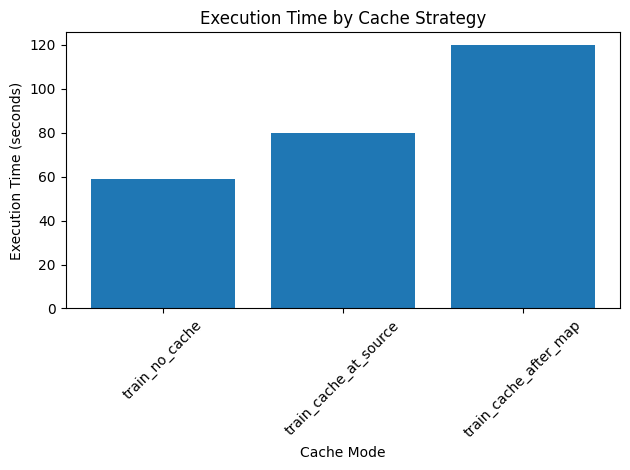

In [140]:
import matplotlib.pyplot as plt

labels = list(results.keys())
times = list(results.values())

# Create bar plot
plt.figure()
plt.bar(labels, times)

plt.xlabel("Cache Mode")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time by Cache Strategy")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## EJERCICIO 3.4

In [17]:
sc.stop()

In [18]:
# read data
result = {}
for i in range(1, 9): # MODIFICAR CUANDO TENGAMOS LA EJECUCION FINAL (CORES + 3)
    sc = SparkContext(f"local[{4}]", f"Prueba_{i}")
    # Ver información del SparkContext
    print(f"Master: {sc.master}")
    print(f"Default parallelism: {sc.defaultParallelism}")
    t0 = perf_counter()
    data=readFile("./botnet_tot_syn_l.csv").repartition(i)
    print(f'Experimento con número de workers 4: particiones={data.getNumPartitions()}')
    rows_rdd = data.map(lambda line: line[0])
    cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
    group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
    mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
    broadcast_var = sc.broadcast(dict(mean_rdd.collect()))
    # standarize
    data = normalize(data)
    ws = train(data,10,1.5,0.0)
    w,b = ws
    acc = accuracy(w,b,data)
    print("acc:",acc)
    time = perf_counter() - t0
    result[i] = time
    sc.stop()
print(result)

Master: local[4]
Default parallelism: 4
Experimento con número de workers 4: particiones=1


Loss en iteracion 0: 0.690891121767007


Loss en iteracion 1: 0.39782222304284215


Loss en iteracion 2: 0.3286594783757808


Loss en iteracion 3: 0.2929002608142005


Loss en iteracion 4: 0.27011842342278614


Loss en iteracion 5: 0.2540488273343712


Loss en iteracion 6: 0.24199661404215023


Loss en iteracion 7: 0.23257497505040384


Loss en iteracion 8: 0.22498472951146412


Loss en iteracion 9: 0.2187278020351212


acc: 0.92944
Master: local[4]
Default parallelism: 4
Experimento con número de workers 4: particiones=2


Loss en iteracion 0: 0.6908911217669448


Loss en iteracion 1: 0.39782222304376336


Loss en iteracion 2: 0.32865947837623705


Loss en iteracion 3: 0.29290026081443543


Loss en iteracion 4: 0.27011842342291364


Loss en iteracion 5: 0.25404882733443535


Loss en iteracion 6: 0.24199661404220205


Loss en iteracion 7: 0.23257497505043465


Loss en iteracion 8: 0.22498472951147103


Loss en iteracion 9: 0.2187278020351126


acc: 0.92944
Master: local[4]
Default parallelism: 4
Experimento con número de workers 4: particiones=3


Loss en iteracion 0: 0.6908911217669459


Loss en iteracion 1: 0.3978222230435862


Loss en iteracion 2: 0.328659478376128


Loss en iteracion 3: 0.2929002608143776


Loss en iteracion 4: 0.27011842342287673


Loss en iteracion 5: 0.2540488273344233


Loss en iteracion 6: 0.24199661404219874


Loss en iteracion 7: 0.23257497505043173


Loss en iteracion 8: 0.22498472951146967


Loss en iteracion 9: 0.21872780203511782


acc: 0.92944
Master: local[4]
Default parallelism: 4
Experimento con número de workers 4: particiones=4


Loss en iteracion 0: 0.6908911217669641


Loss en iteracion 1: 0.39782222304340464


Loss en iteracion 2: 0.3286594783760316


Loss en iteracion 3: 0.2929002608143124


Loss en iteracion 4: 0.2701184234228289


Loss en iteracion 5: 0.2540488273343836


Loss en iteracion 6: 0.24199661404216946


Loss en iteracion 7: 0.23257497505040653


Loss en iteracion 8: 0.22498472951144727


Loss en iteracion 9: 0.2187278020350967


acc: 0.92944
Master: local[4]
Default parallelism: 4
Experimento con número de workers 4: particiones=5


Loss en iteracion 0: 0.6908911217669664


Loss en iteracion 1: 0.39782222304349746


Loss en iteracion 2: 0.3286594783760807


Loss en iteracion 3: 0.29290026081433684


Loss en iteracion 4: 0.27011842342283926


Loss en iteracion 5: 0.2540488273343869


Loss en iteracion 6: 0.24199661404216927


Loss en iteracion 7: 0.2325749750504026


Loss en iteracion 8: 0.22498472951144244


Loss en iteracion 9: 0.21872780203509398


acc: 0.92944
Master: local[4]
Default parallelism: 4
Experimento con número de workers 4: particiones=6


Loss en iteracion 0: 0.6908911217669632


Loss en iteracion 1: 0.39782222304361964


Loss en iteracion 2: 0.3286594783761502


Loss en iteracion 3: 0.2929002608143791


Loss en iteracion 4: 0.27011842342286496


Loss en iteracion 5: 0.25404882733440304


Loss en iteracion 6: 0.24199661404217956


Loss en iteracion 7: 0.23257497505040994


Loss en iteracion 8: 0.22498472951144943


Loss en iteracion 9: 0.21872780203509706


acc: 0.92944
Master: local[4]
Default parallelism: 4
Experimento con número de workers 4: particiones=7


Loss en iteracion 0: 0.6908911217669617


Loss en iteracion 1: 0.39782222304373127


Loss en iteracion 2: 0.32865947837621595


Loss en iteracion 3: 0.2929002608144255


Loss en iteracion 4: 0.27011842342289805


Loss en iteracion 5: 0.25404882733442957


Loss en iteracion 6: 0.2419966140421981


Loss en iteracion 7: 0.23257497505042696


Loss en iteracion 8: 0.2249847295114649


Loss en iteracion 9: 0.21872780203511005


acc: 0.92944
Master: local[4]
Default parallelism: 4
Experimento con número de workers 4: particiones=8


[Stage 10:>                                                         (0 + 4) / 8]

Loss en iteracion 0: 0.6908911217669622


Loss en iteracion 1: 0.39782222304376946


Loss en iteracion 2: 0.3286594783762404


Loss en iteracion 3: 0.29290026081444637


Loss en iteracion 4: 0.2701184234229153


Loss en iteracion 5: 0.25404882733444484


Loss en iteracion 6: 0.24199661404221195


Loss en iteracion 7: 0.23257497505044017


Loss en iteracion 8: 0.22498472951147697


Loss en iteracion 9: 0.218727802035122


acc: 0.92944
{1: 120.430280549, 2: 87.01824002500001, 3: 60.84650670899998, 4: 55.30078099399998, 5: 68.94140135400005, 6: 64.34930971300003, 7: 56.546179370000004, 8: 56.27515748799999}


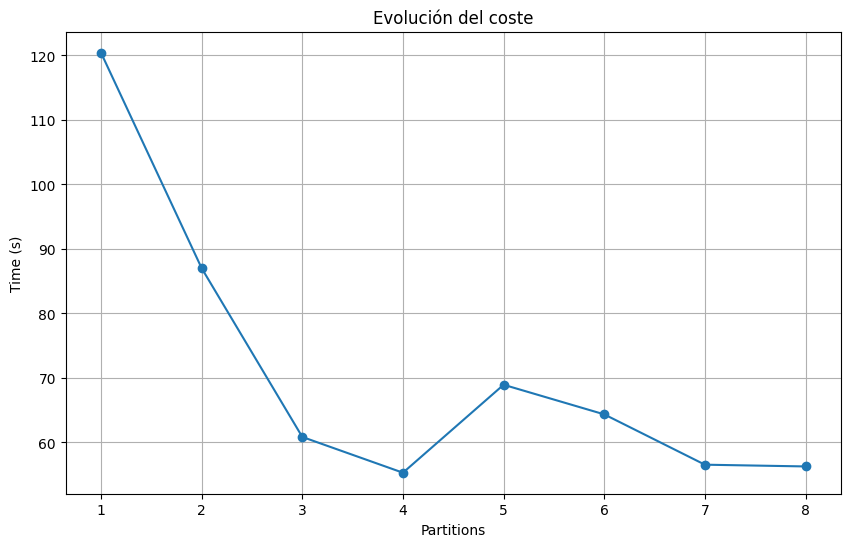

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

xs = sorted(result.keys())
ys = [result[x] for x in xs]

plt.plot(xs, ys, marker='o')   # línea + puntos
plt.xlabel("Partitions")
plt.ylabel("Time (s)")
plt.title("Evolución del coste")
plt.grid(True)
plt.show()

## EJERCICIO 3.5

In [21]:
sc.stop()

In [22]:
# read data
result = {}
for i in range(1, 11): # MODIFICAR CUANDO TENGAMOS LA EJECUCION FINAL (CORES + 3)
    sc = SparkContext(f"local[{i}]", f"Prueba_{i}")
    t0 = perf_counter()
    data=readFile("./botnet_tot_syn_l.csv").repartition(2)
    print(f'Experimento con número de workers {i}: particiones={data.getNumPartitions()}')
    rows_rdd = data.map(lambda line: line[0])
    cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
    group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
    mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
    broadcast_var = sc.broadcast(dict(mean_rdd.collect()))
    # standarize
    data = normalize(data)
    ws = train(data,10,1.5,0.0)
    w,b = ws
    acc = accuracy(w,b,data)
    print("acc:",acc)
    time = perf_counter() - t0
    result[i] = time
    sc.stop()
print(result)

Experimento con número de workers 1: particiones=2


Loss en iteracion 0: 0.6908911217669448


Loss en iteracion 1: 0.39782222304376336


Loss en iteracion 2: 0.32865947837623705


Loss en iteracion 3: 0.29290026081443543


Loss en iteracion 4: 0.27011842342291364


Loss en iteracion 5: 0.25404882733443535


Loss en iteracion 6: 0.24199661404220205


Loss en iteracion 7: 0.23257497505043465


Loss en iteracion 8: 0.22498472951147103


Loss en iteracion 9: 0.2187278020351126


acc: 0.92944
Experimento con número de workers 2: particiones=2


Loss en iteracion 0: 0.6908911217669448


Loss en iteracion 1: 0.39782222304376336


Loss en iteracion 2: 0.32865947837623705


Loss en iteracion 3: 0.29290026081443543


Loss en iteracion 4: 0.27011842342291364


Loss en iteracion 5: 0.25404882733443535


Loss en iteracion 6: 0.24199661404220205


Loss en iteracion 7: 0.23257497505043465


Loss en iteracion 8: 0.22498472951147103


Loss en iteracion 9: 0.2187278020351126


acc: 0.92944
Experimento con número de workers 3: particiones=2


Loss en iteracion 0: 0.6908911217669448


Loss en iteracion 1: 0.39782222304376336


Loss en iteracion 2: 0.32865947837623705


Loss en iteracion 3: 0.29290026081443543


Loss en iteracion 4: 0.27011842342291364


Loss en iteracion 5: 0.25404882733443535


Loss en iteracion 6: 0.24199661404220205


Loss en iteracion 7: 0.23257497505043465


Loss en iteracion 8: 0.22498472951147103


Loss en iteracion 9: 0.2187278020351126


acc: 0.92944
Experimento con número de workers 4: particiones=2


Loss en iteracion 0: 0.6908911217669448


Loss en iteracion 1: 0.39782222304376336


Loss en iteracion 2: 0.32865947837623705


Loss en iteracion 3: 0.29290026081443543


Loss en iteracion 4: 0.27011842342291364


Loss en iteracion 5: 0.25404882733443535


Loss en iteracion 6: 0.24199661404220205


Loss en iteracion 7: 0.23257497505043465


Loss en iteracion 8: 0.22498472951147103


Loss en iteracion 9: 0.2187278020351126


acc: 0.92944
Experimento con número de workers 5: particiones=2


Loss en iteracion 0: 0.6908911217669448


Loss en iteracion 1: 0.39782222304376336


Loss en iteracion 2: 0.32865947837623705


Loss en iteracion 3: 0.29290026081443543


Loss en iteracion 4: 0.27011842342291364


Loss en iteracion 5: 0.25404882733443535


Loss en iteracion 6: 0.24199661404220205


Loss en iteracion 7: 0.23257497505043465


Loss en iteracion 8: 0.22498472951147103


Loss en iteracion 9: 0.2187278020351126


acc: 0.92944
Experimento con número de workers 6: particiones=2


Loss en iteracion 0: 0.6908911217669448


Loss en iteracion 1: 0.39782222304376336


Loss en iteracion 2: 0.32865947837623705


Loss en iteracion 3: 0.29290026081443543


Loss en iteracion 4: 0.27011842342291364


Loss en iteracion 5: 0.25404882733443535


Loss en iteracion 6: 0.24199661404220205


Loss en iteracion 7: 0.23257497505043465


Loss en iteracion 8: 0.22498472951147103


Loss en iteracion 9: 0.2187278020351126


acc: 0.92944
Experimento con número de workers 7: particiones=2


Loss en iteracion 0: 0.6908911217669448


Loss en iteracion 1: 0.39782222304376336


Loss en iteracion 2: 0.32865947837623705


Loss en iteracion 3: 0.29290026081443543


Loss en iteracion 4: 0.27011842342291364


Loss en iteracion 5: 0.25404882733443535


Loss en iteracion 6: 0.24199661404220205


Loss en iteracion 7: 0.23257497505043465


Loss en iteracion 8: 0.22498472951147103


Loss en iteracion 9: 0.2187278020351126


acc: 0.92944
Experimento con número de workers 8: particiones=2


Loss en iteracion 0: 0.6908911217669448


Loss en iteracion 1: 0.39782222304376336


Loss en iteracion 2: 0.32865947837623705


Loss en iteracion 3: 0.29290026081443543


Loss en iteracion 4: 0.27011842342291364


Loss en iteracion 5: 0.25404882733443535


Loss en iteracion 6: 0.24199661404220205


Loss en iteracion 7: 0.23257497505043465


Loss en iteracion 8: 0.22498472951147103


Loss en iteracion 9: 0.2187278020351126


acc: 0.92944
Experimento con número de workers 9: particiones=2


Loss en iteracion 0: 0.6908911217669448


Loss en iteracion 1: 0.39782222304376336


Loss en iteracion 2: 0.32865947837623705


Loss en iteracion 3: 0.29290026081443543


Loss en iteracion 4: 0.27011842342291364


Loss en iteracion 5: 0.25404882733443535


Loss en iteracion 6: 0.24199661404220205


Loss en iteracion 7: 0.23257497505043465


Loss en iteracion 8: 0.22498472951147103


Loss en iteracion 9: 0.2187278020351126


acc: 0.92944
Experimento con número de workers 10: particiones=2


Loss en iteracion 0: 0.6908911217669448


Loss en iteracion 1: 0.39782222304376336


Loss en iteracion 2: 0.32865947837623705


Loss en iteracion 3: 0.29290026081443543


Loss en iteracion 4: 0.27011842342291364


Loss en iteracion 5: 0.25404882733443535


Loss en iteracion 6: 0.24199661404220205


Loss en iteracion 7: 0.23257497505043465


Loss en iteracion 8: 0.22498472951147103


Loss en iteracion 9: 0.2187278020351126


acc: 0.92944
{1: 115.58565463699995, 2: 77.43516487399995, 3: 82.00260818400011, 4: 80.01105296700007, 5: 79.38154795900005, 6: 88.54202067599999, 7: 77.74442430500017, 8: 72.26059206199989, 9: 79.53756297599989, 10: 77.83591454399993}


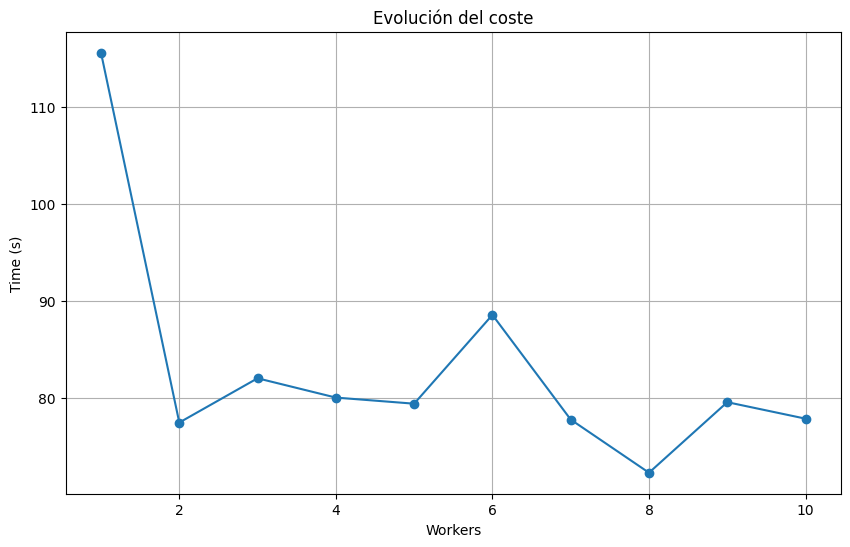

In [24]:
plt.figure(figsize=(10, 6))

xs = sorted(result.keys())
ys = [result[x] for x in xs]

plt.plot(xs, ys, marker='o')   # línea + puntos
plt.xlabel("Workers")
plt.ylabel("Time (s)")
plt.title("Evolución del coste")
plt.grid(True)
plt.show()

In [14]:
sc.stop()